In [1]:
import pickle, os, gzip, json
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import pynndescent
from sklearn.feature_extraction.text import TfidfTransformer
import umap
import scipy as sp

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300

import sys
sys.path.append("../../scripts")

## Load data

In [2]:
import data_io
reload(data_io)
from data_io import is_fwd_id, get_fwd_id, get_sibling_id

import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
)

import truth
reload(truth)
from truth import get_overlaps


import graph
reload(graph)
from graph import ReadGraph, GenomicInterval

/home/ecs-user/workspace/kNN-overlap-finder/scripts/../lib


In [3]:
sample = "CHM13"
region = "HLA"
dataset = "pbsim_ONT_93_30k"
sample_size = 6_000

prefix = f"../../data/feature_matrix/kmer/{sample}/{region}/{dataset}/"

npz_path = os.path.join(prefix, "feature_matrix.npz")
tsv_path = os.path.join(prefix, "metadata.tsv.gz")
json_path = os.path.join(prefix, "read_features.json.gz")

feature_matrix = sp.sparse.load_npz(npz_path)[:sample_size, :]
meta_df = pd.read_table(tsv_path).iloc[:sample_size, :].set_index("read_id")

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)[:sample_size]
    read_features = {i: features for i, features in enumerate(read_features)}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

Text(0, 0.5, 'Number of reads')

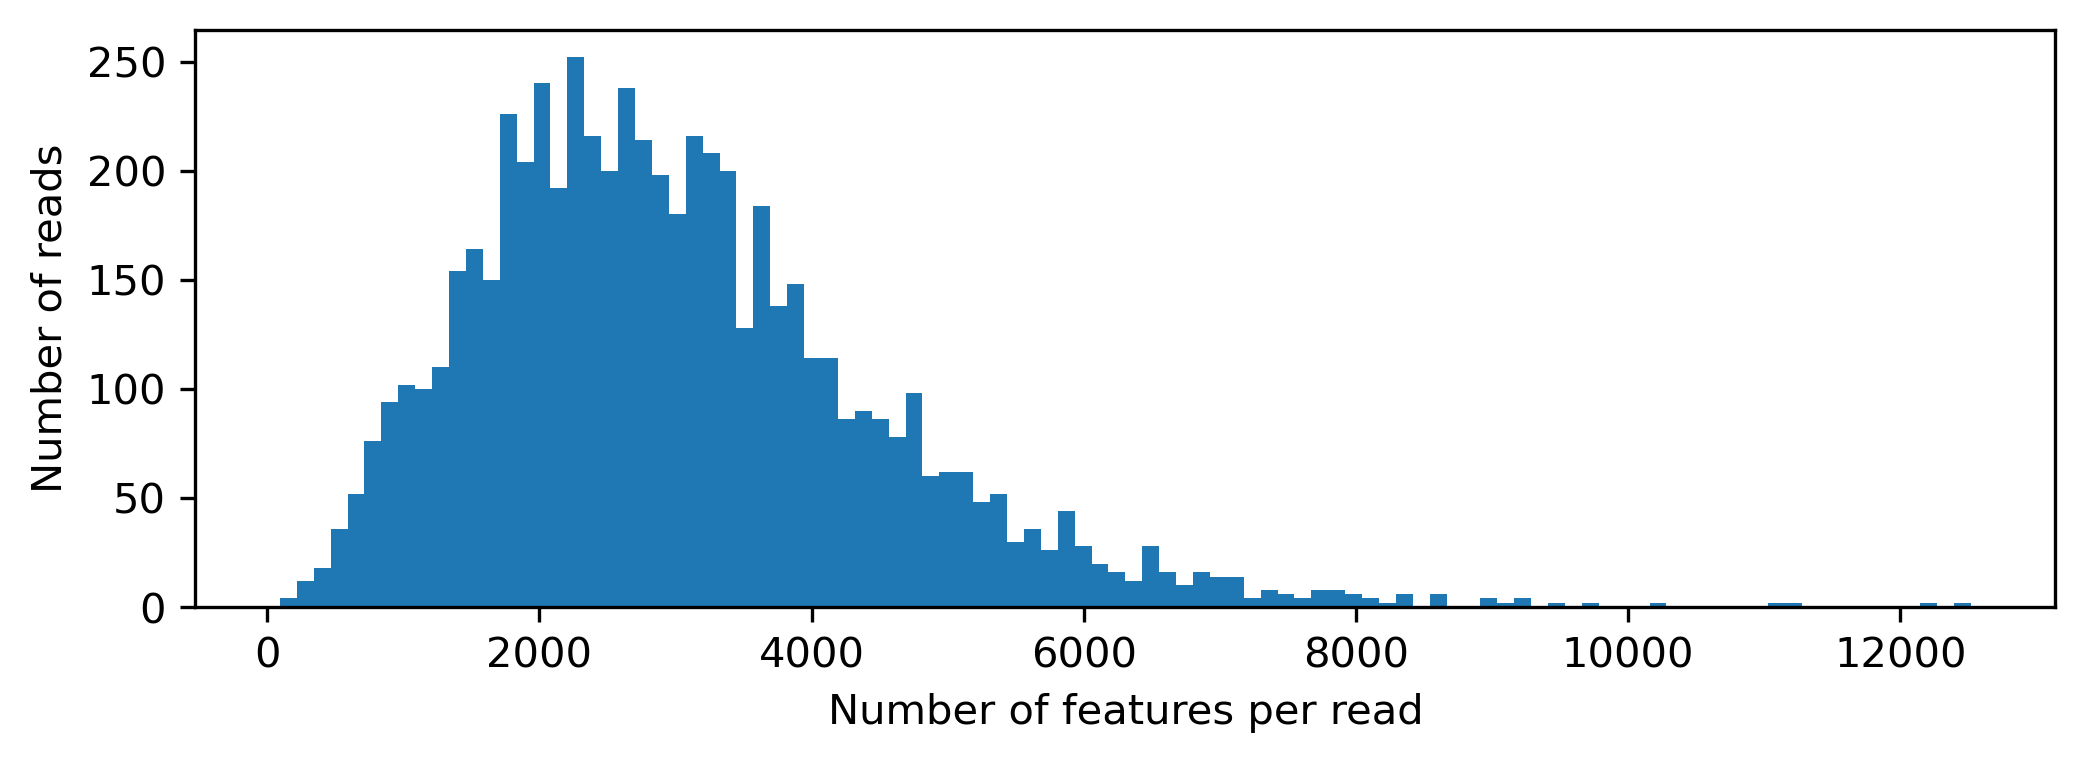

In [4]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100);
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")

In [5]:
feature_matrix.shape

(6000, 102784)

In [6]:
meta_df

read_name read_orientation  read_length reference_strand  \
read_id                                                            
0            S1_1                +        54465                +   
1            S1_1                -        54465                -   
2            S1_2                +        47954                -   
3            S1_2                -        47954                +   
4            S1_3                +        13367                +   
...           ...              ...          ...              ...   
5995      S1_2998                -        21881                +   
5996      S1_2999                +        70839                +   
5997      S1_2999                -        70839                -   
5998      S1_3000                +        49644                -   
5999      S1_3000                -        49644                +   

         reference_start  reference_end  
read_id                                  
0                5454581        5509219  
1                5454581        5509219  
2                4794670        4842830  
3                4794670        4842830  
4                5150656        5164902  
...                  ...            ...  
5995              807673         829579  
5996             2913643        2984988  
5997             2913643        2984988  
5998             2855743        2906235  
5999             2855743        2906235  

[6000 rows x 6 columns]

In [7]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

6000

In [8]:
reference_graph = ReadGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(6000, 94230, 11540, 2)

## Get nearest neighbours

In [26]:
import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    _NearestNeighbors
)

In [27]:
import evaluate
reload(evaluate)
from evaluate import NearestNeighborsConfig, mp_evaluate_configs

In [61]:
config_list = [
    # NearestNeighborsConfig(
    #     method=ExactNearestNeighbors,
    #     use_tfidf=False,
    #     dim_reduction=100,
    #     n_neighbors=24,
    #     nearest_neighbor_kw=dict(metric="cosine"),
    # ),
    # NearestNeighborsConfig(
    #     method=ExactNearestNeighbors,
    #     use_tfidf=True,
    #     dim_reduction=None,
    #     n_neighbors=24,
    #     nearest_neighbor_kw=dict(metric="cosine"),
    # ),
    # NearestNeighborsConfig(
    #     method=ExactNearestNeighbors,
    #     use_tfidf=True,
    #     dim_reduction=100,
    #     n_neighbors=24,
    #     nearest_neighbor_kw=dict(metric="cosine"),
    # ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=None,
        n_neighbors=12,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=12,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=100,
        n_neighbors=12,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=12,
        nearest_neighbor_kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=True,
        n_neighbors=12,
        require_mutual_neighbors=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        require_mutual_neighbors=True,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=True,
        n_neighbors=12,
        require_mutual_neighbors=True,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
]

In [62]:
%%time
pickle_file = f"data/pickle/{sample}_{region}_{dataset}_alignment_dict.pickle.gz"
mp_evaluate_configs(
    config_list,
    alignment_pickle_path=pickle_file,
    feature_matrix=feature_matrix,
    feature_weights=feature_weights,
    read_features=read_features,
    post_align_n_neighbors=6,
    processes=8,
    batch_size=1_000,
    reference_graph=reference_graph,
)

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=False, dim_reduction=None, n_neighbors=12, elapsed_time=None, require_mutual_neighbors=False, pre_align_stats=None, post_align_intersect=False, post_align_stats=None)

 Pre-alignment: precision=0.220 nr_precision=0.108 recall=0.143 nr_recall=0.602 

len(candidates)=57356	len(cached_candidates)=57356	len(new_candidates)=0

 Post-alignment: precision=0.505 nr_precision=0.251 recall=0.085 nr_recall=0.361 

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=True, dim_reduction=None, n_neighbors=12, elapsed_time=None, require_mutual_neighbors=False, pre_align_stats=None, post_align_intersect=False, post_align_stats=None)

 Pre-alignment: precision=0.485 nr_precision=0.203 recall=0.250 nr_recall=0.894 

len(candidates)=45428	len(cached_candidates)=45428	len(new_candidates)=0

 Post-alignment: precision=0.502 nr_precision=0.216 recall=0.111 nr_recall=0.407 

Neare

## Visualisation

In [63]:
# Plots
import plots
reload(plots)
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

In [65]:
def plot_configs(configs, reference_graph, metadata, *, show_singletons=False, **kw):
    graphs = [config.post_align_graph.copy() for config in configs] + [reference_graph]
    
    for g in graphs:
        singletons = []
        for node in g.nodes:
            if len(g[node]) <= 1:
                singletons.append(node)
        g.remove_nodes_from(singletons)

    figures, axes = mp_plot_read_graphs(
        graphs, reference_graph=reference_graph, metadata=metadata, **kw
    )
    for ax, config in zip(axes, configs):
        ax.text(
            0, 0, str(config), ha="left", va="bottom", transform=ax.transAxes, wrap=True
        )
        ax.axis("off")
    return figures, axes

2 3 6 5 7 0 4 1 8 
CPU times: user 22.9 s, sys: 964 ms, total: 23.9 s
Wall time: 50.5 s


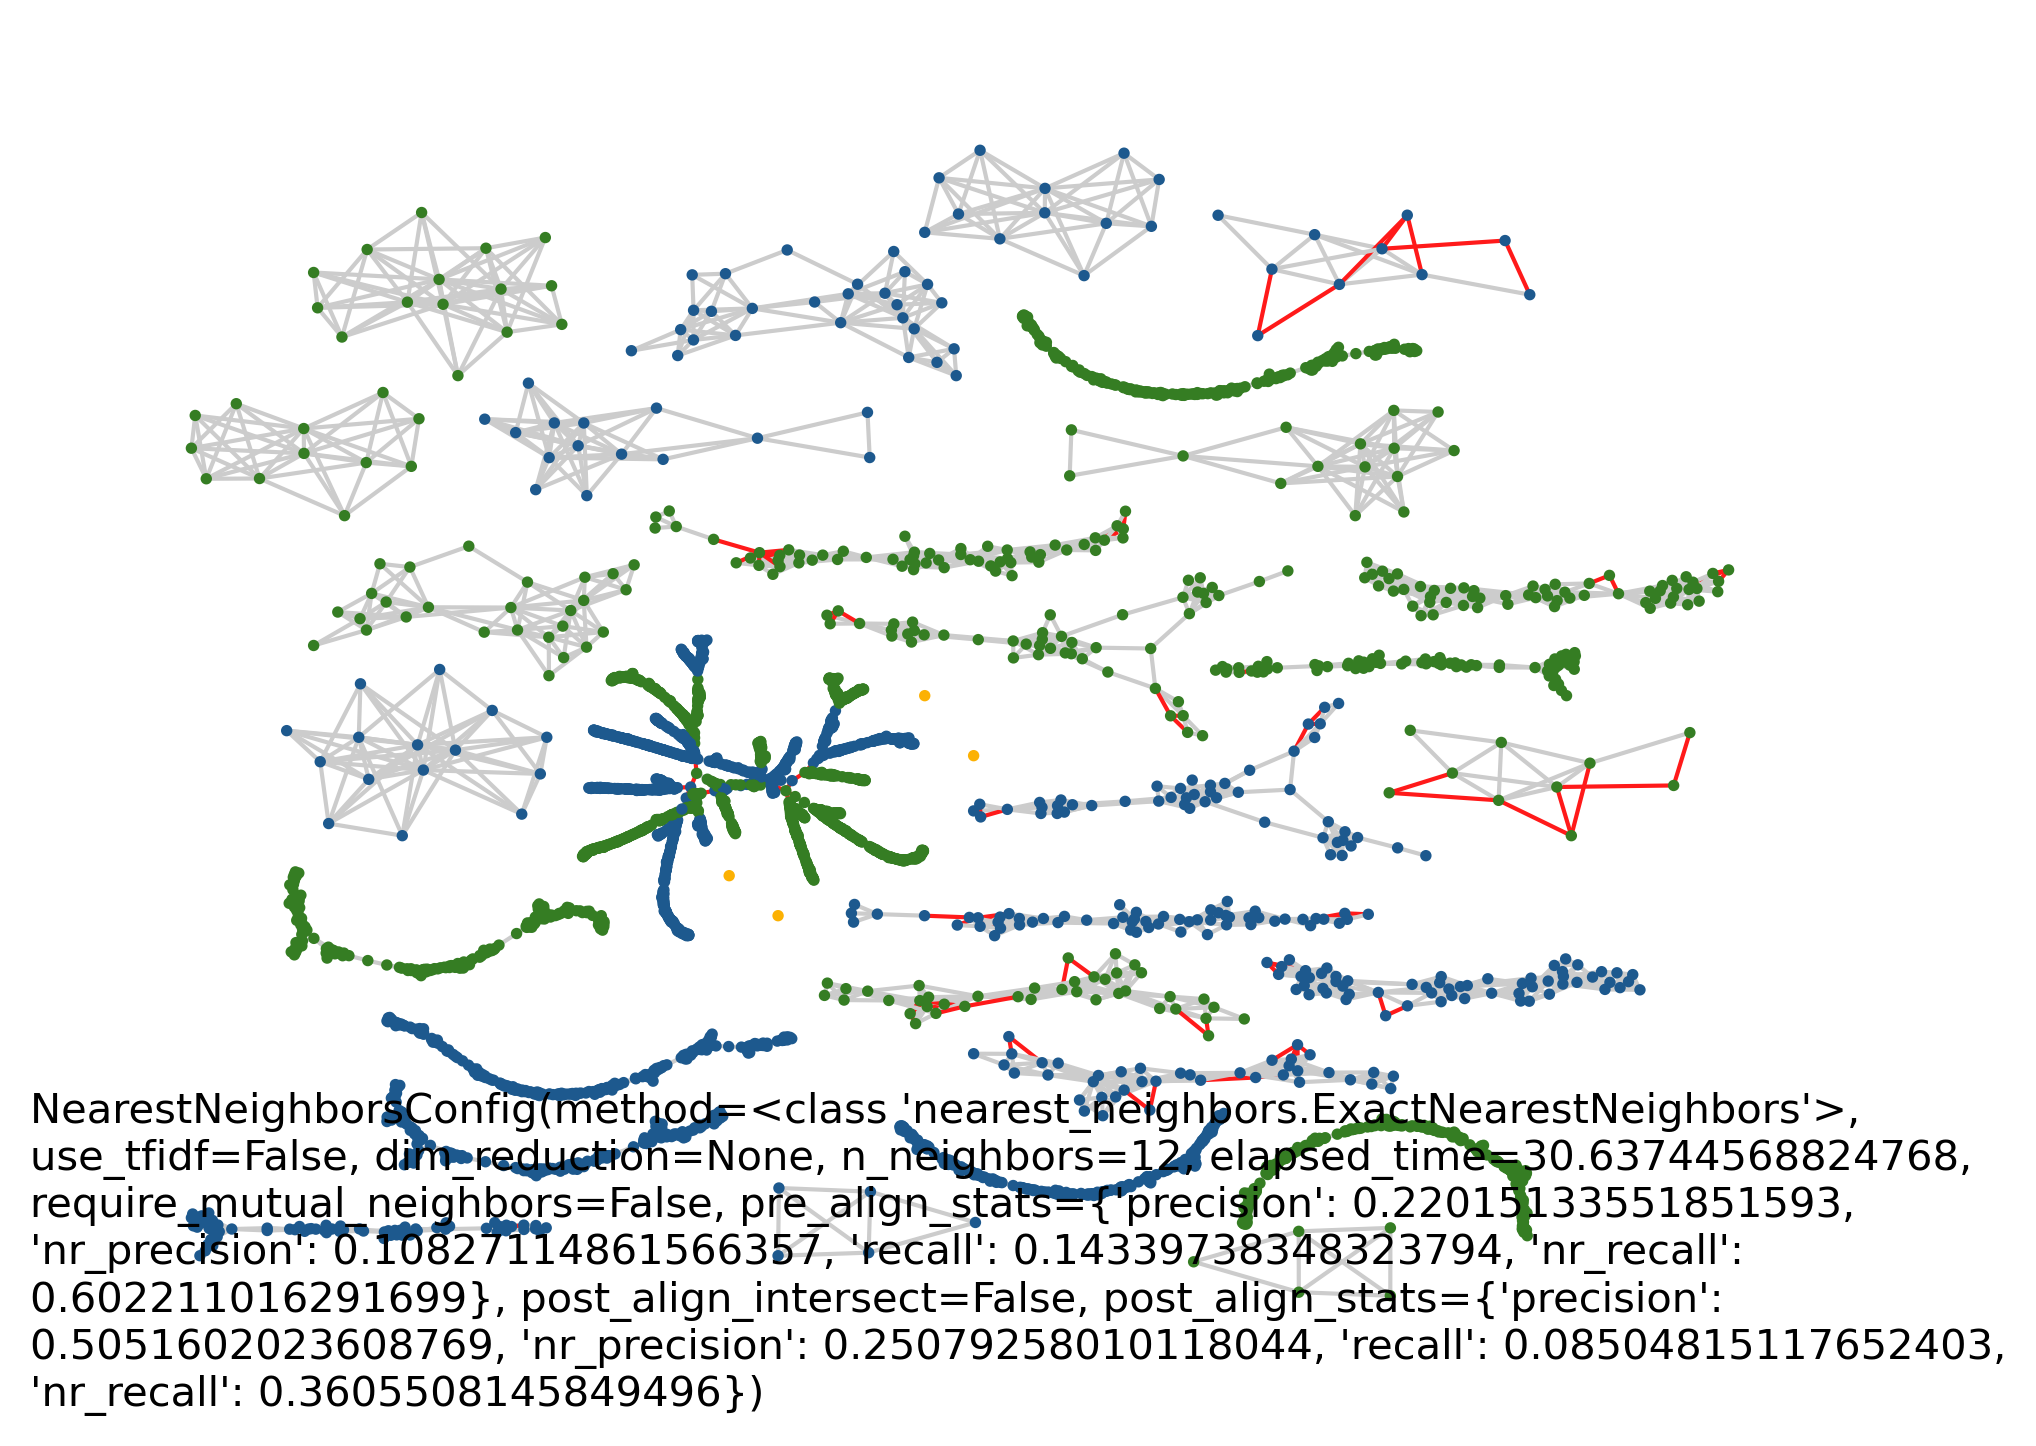

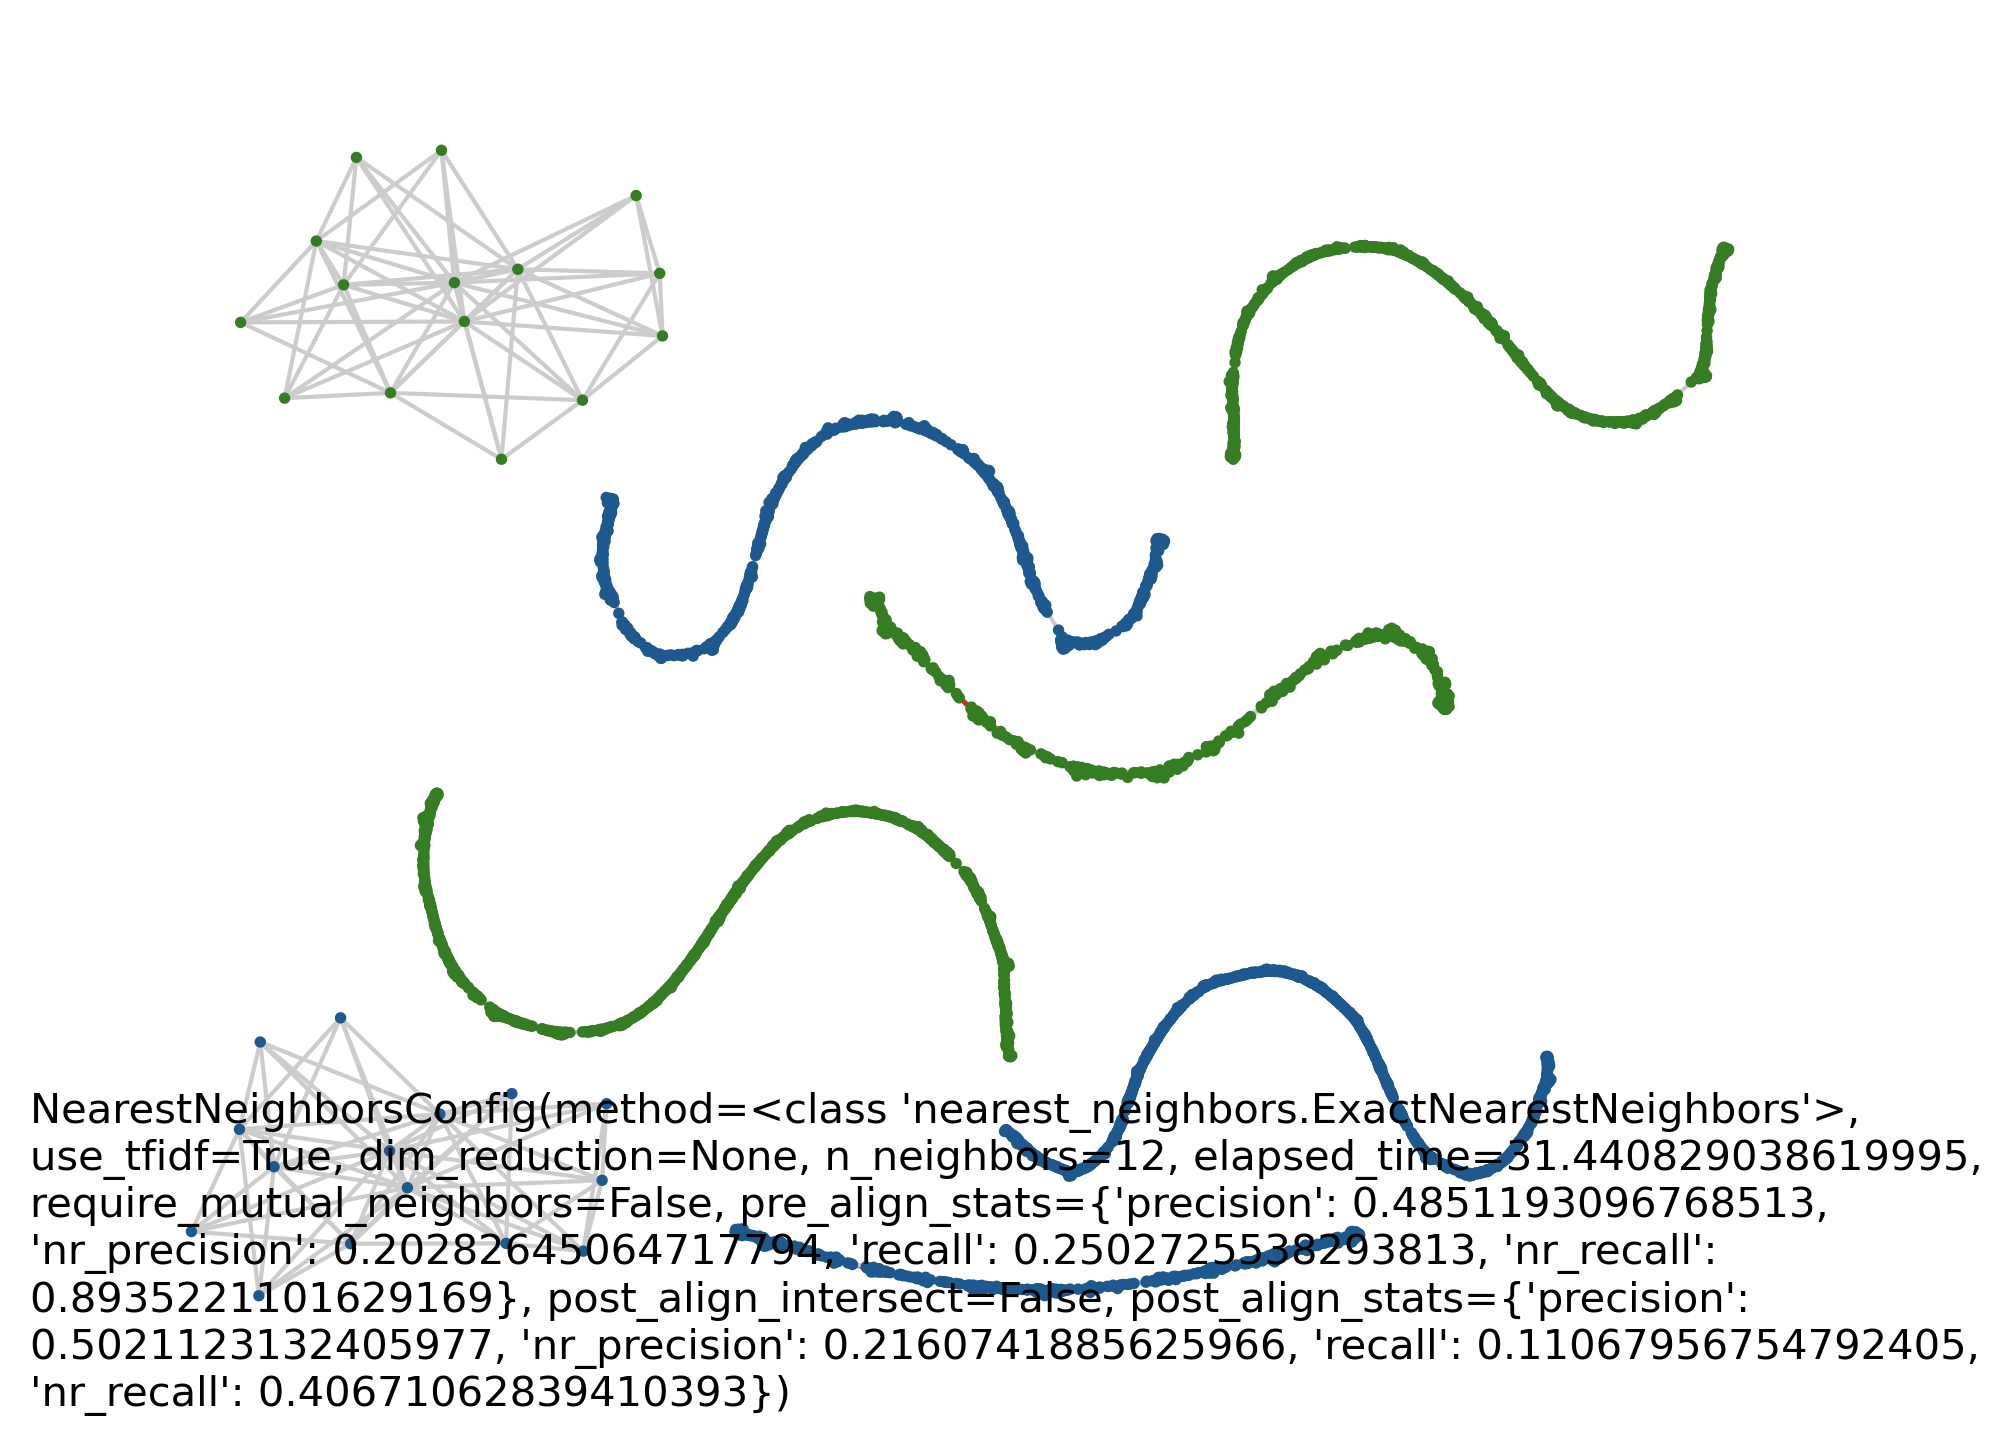

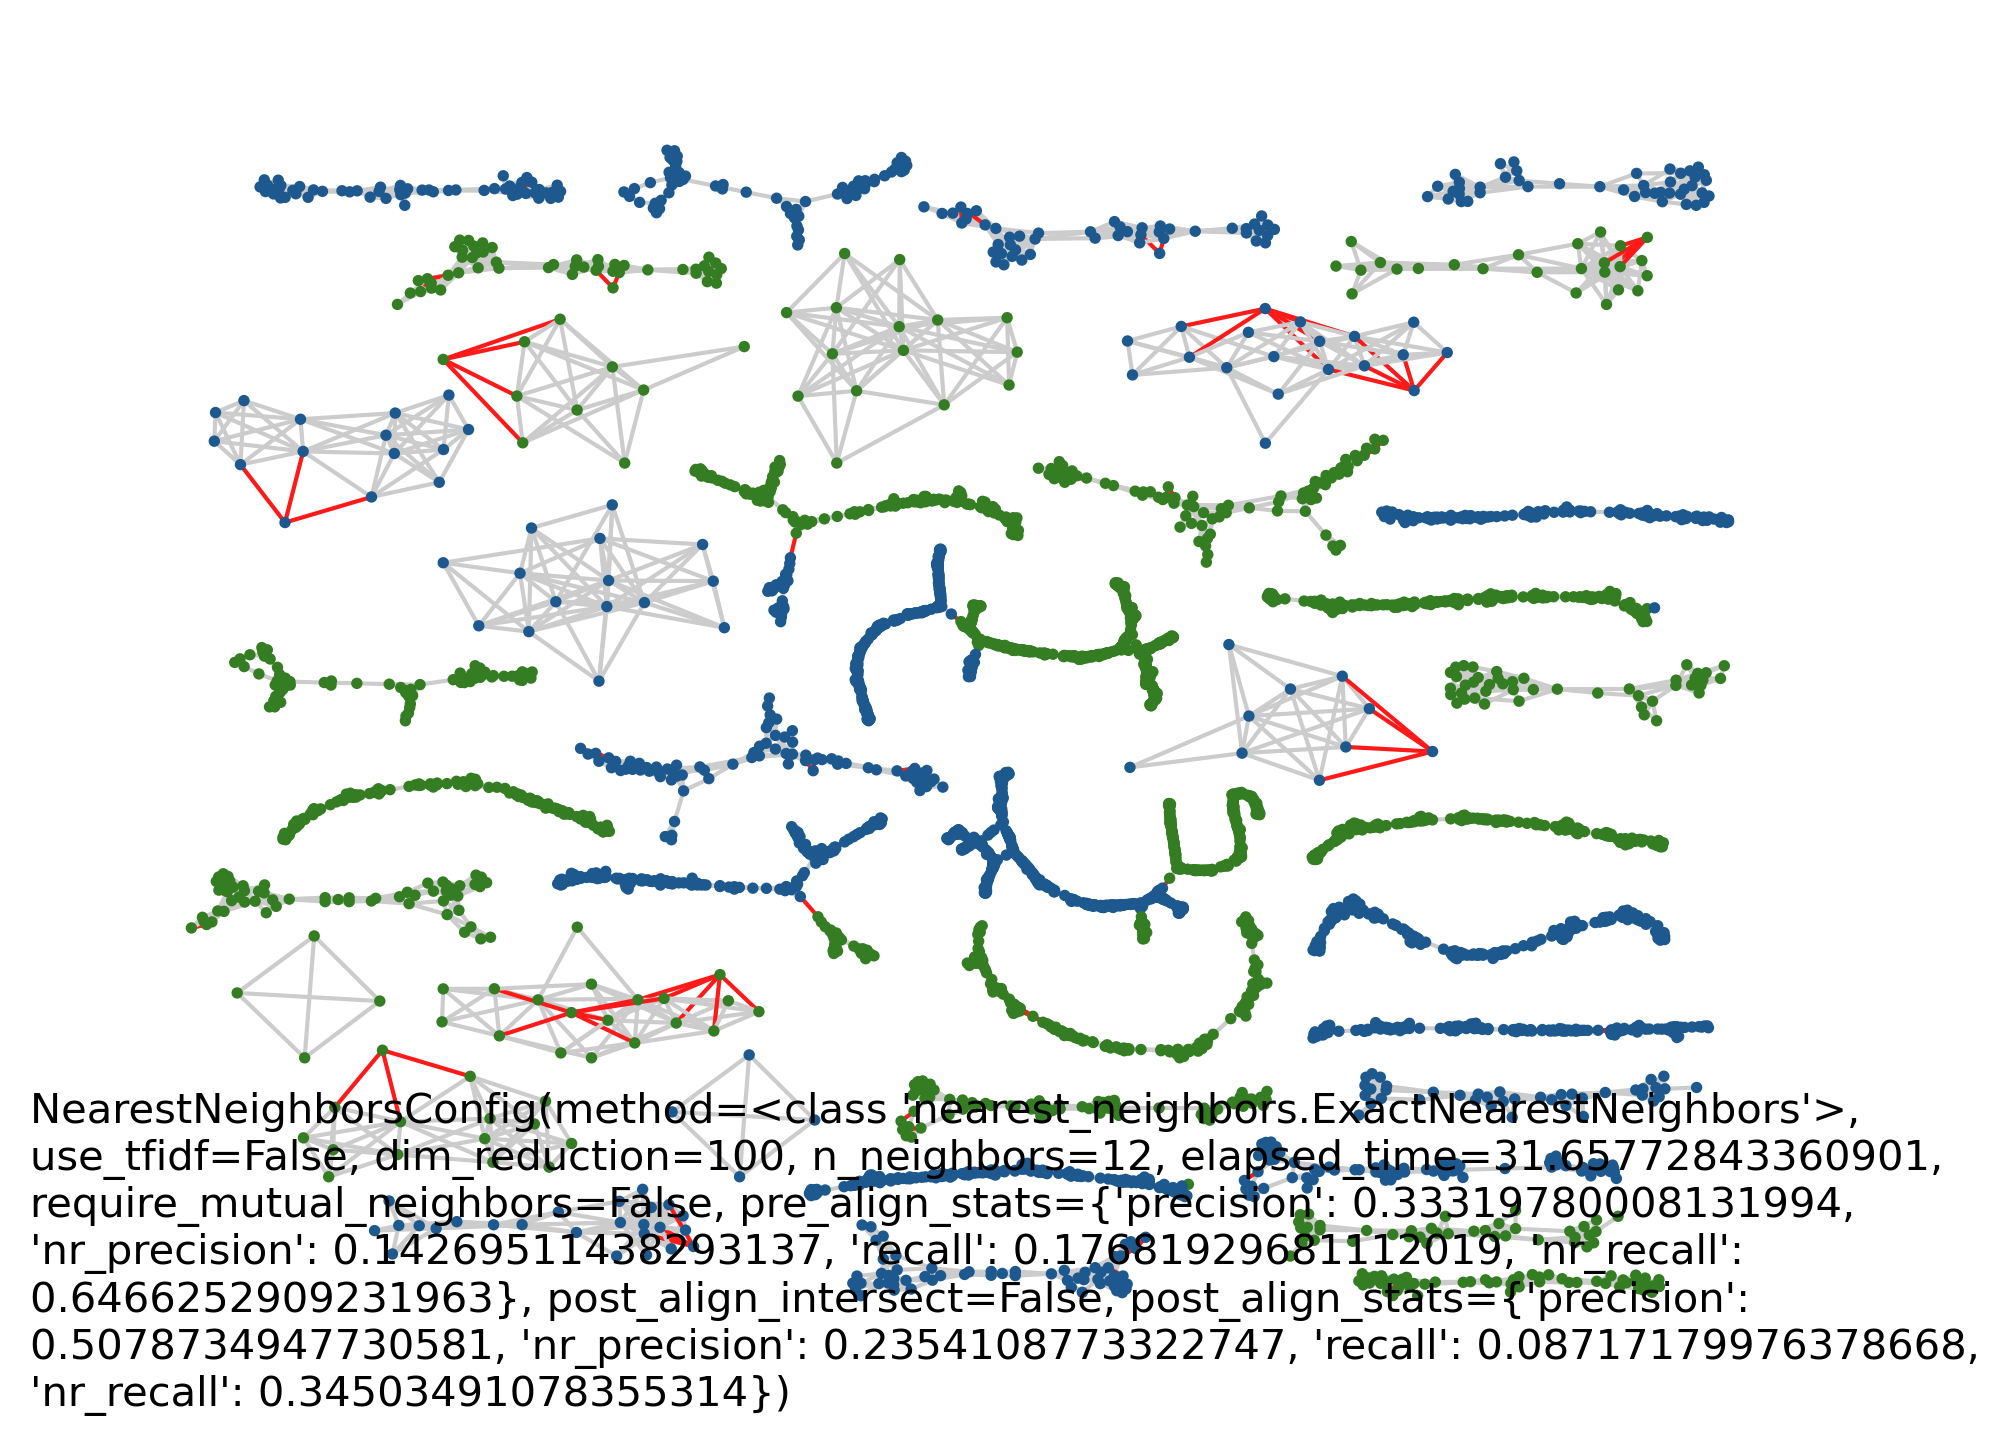

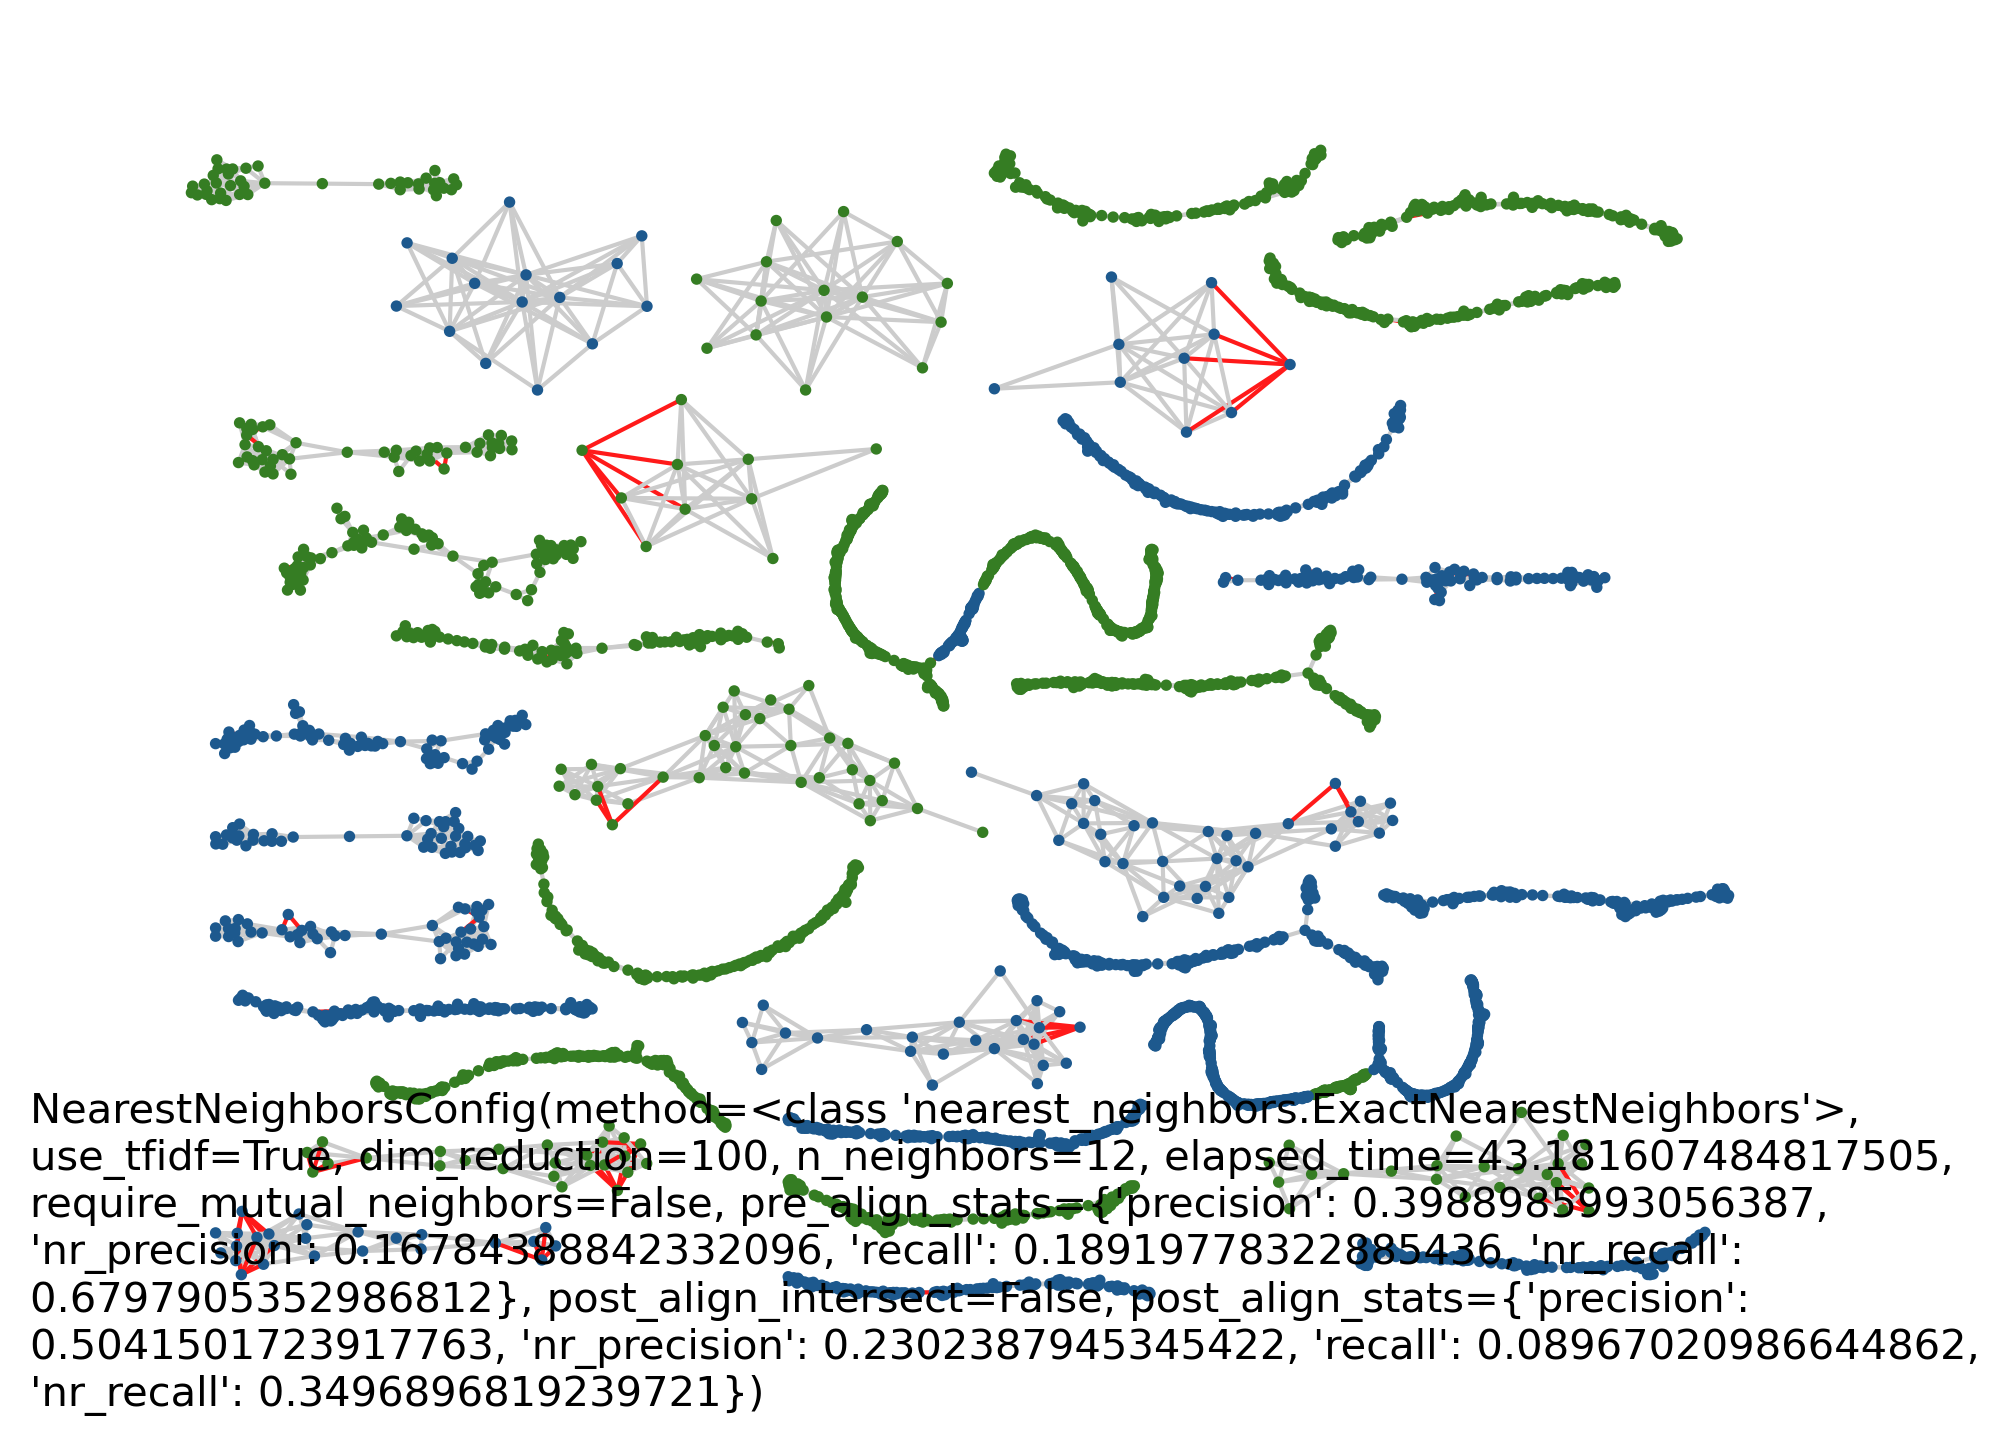

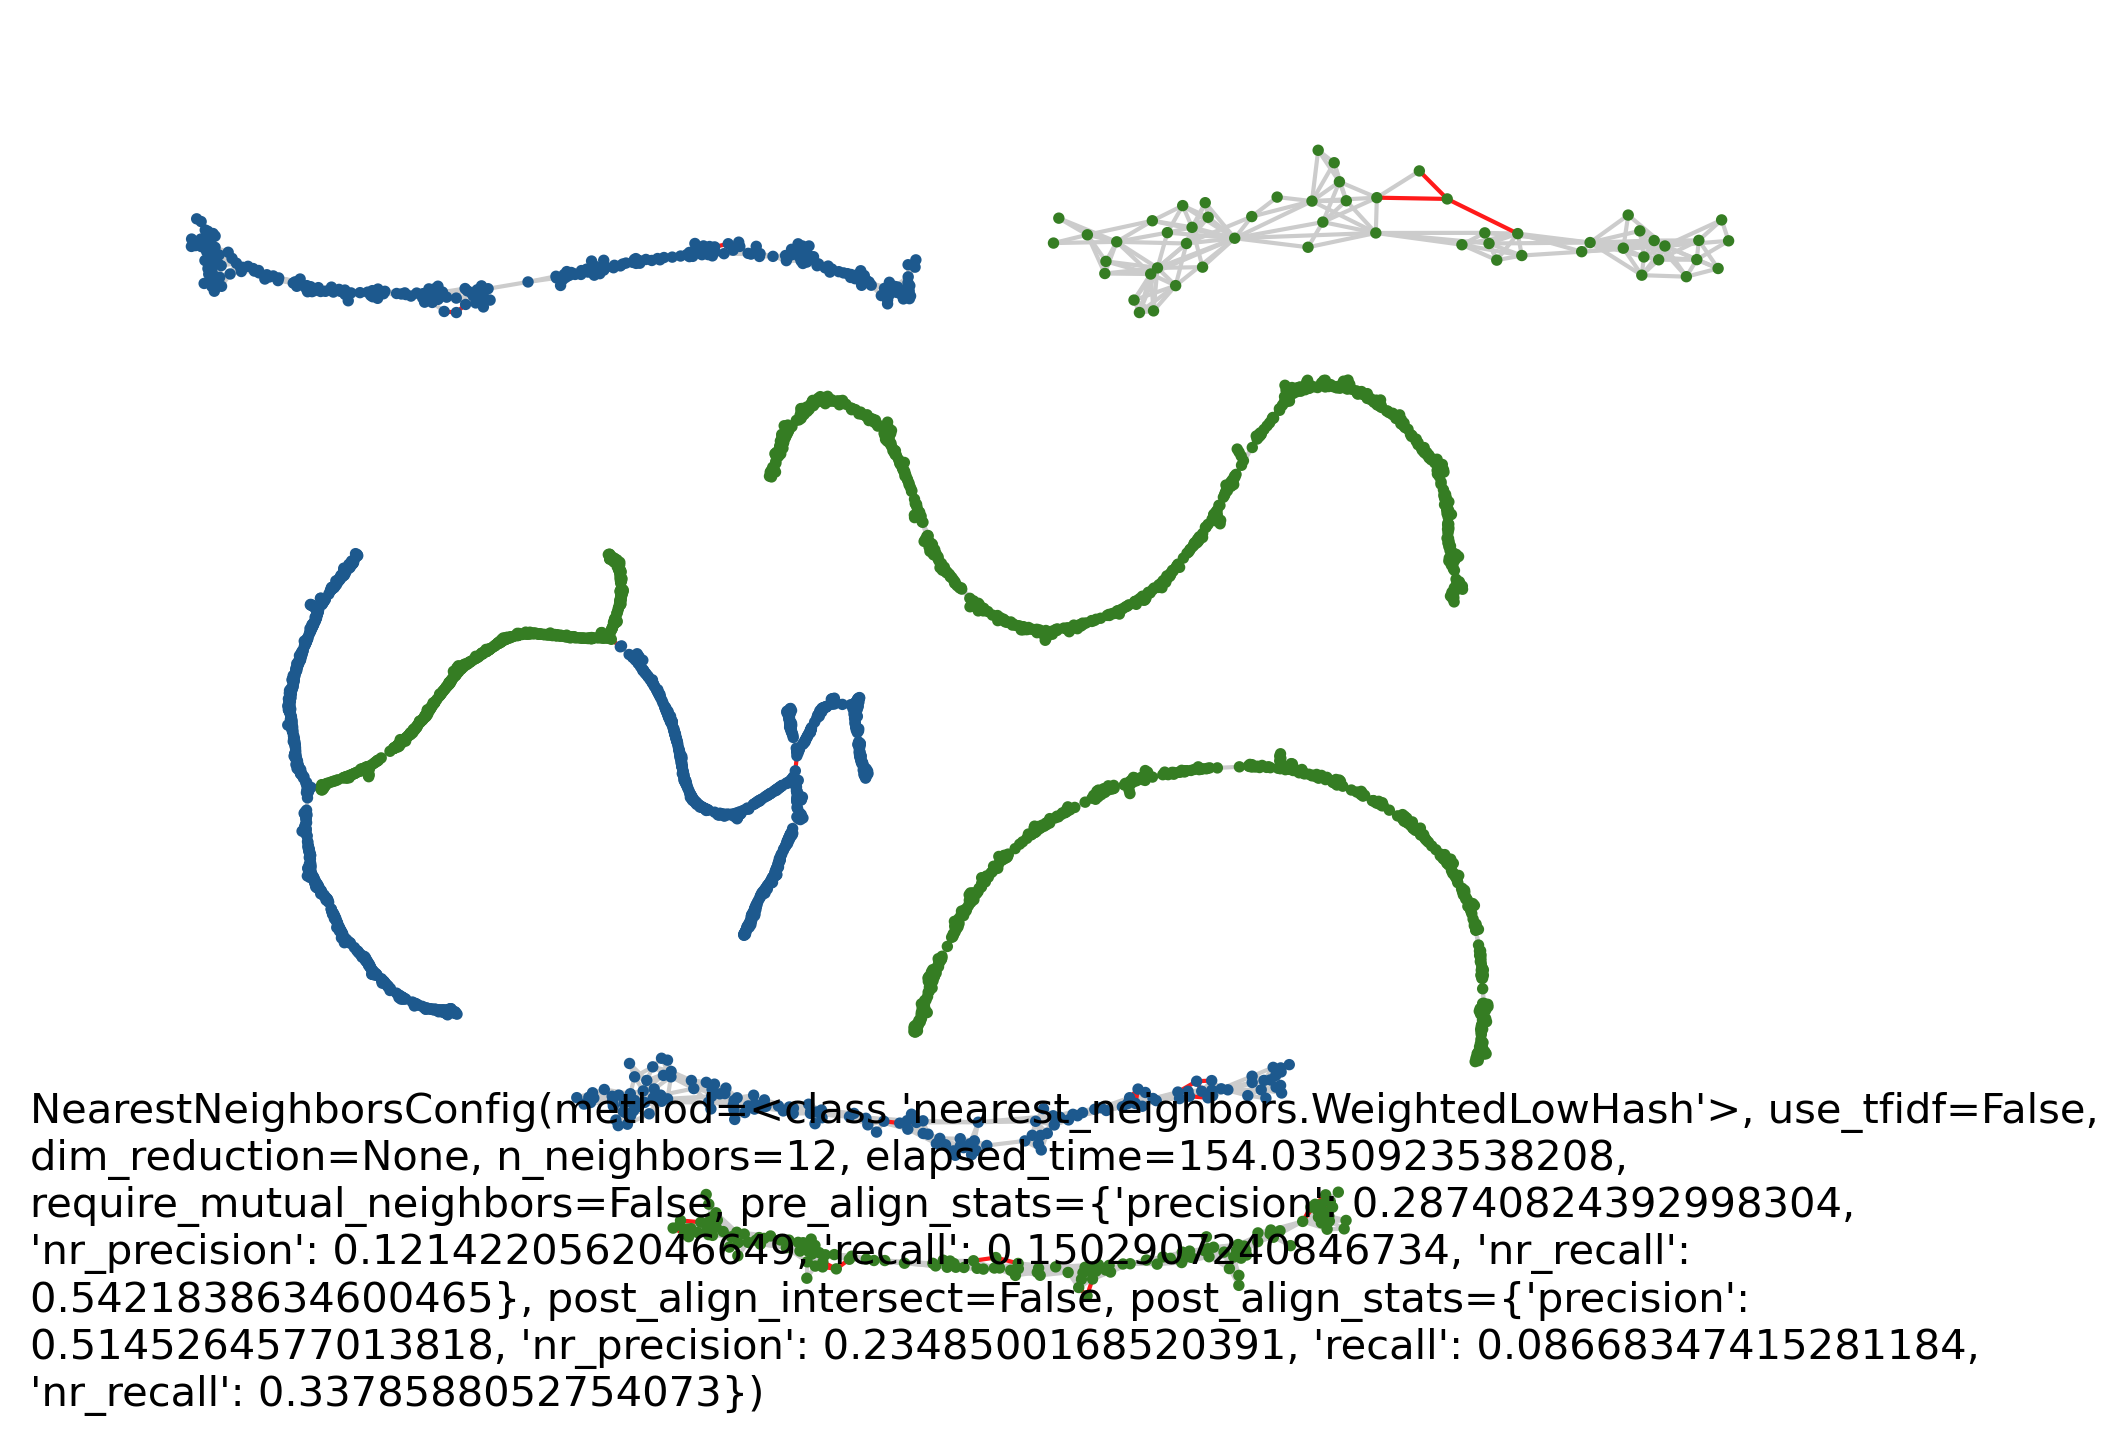

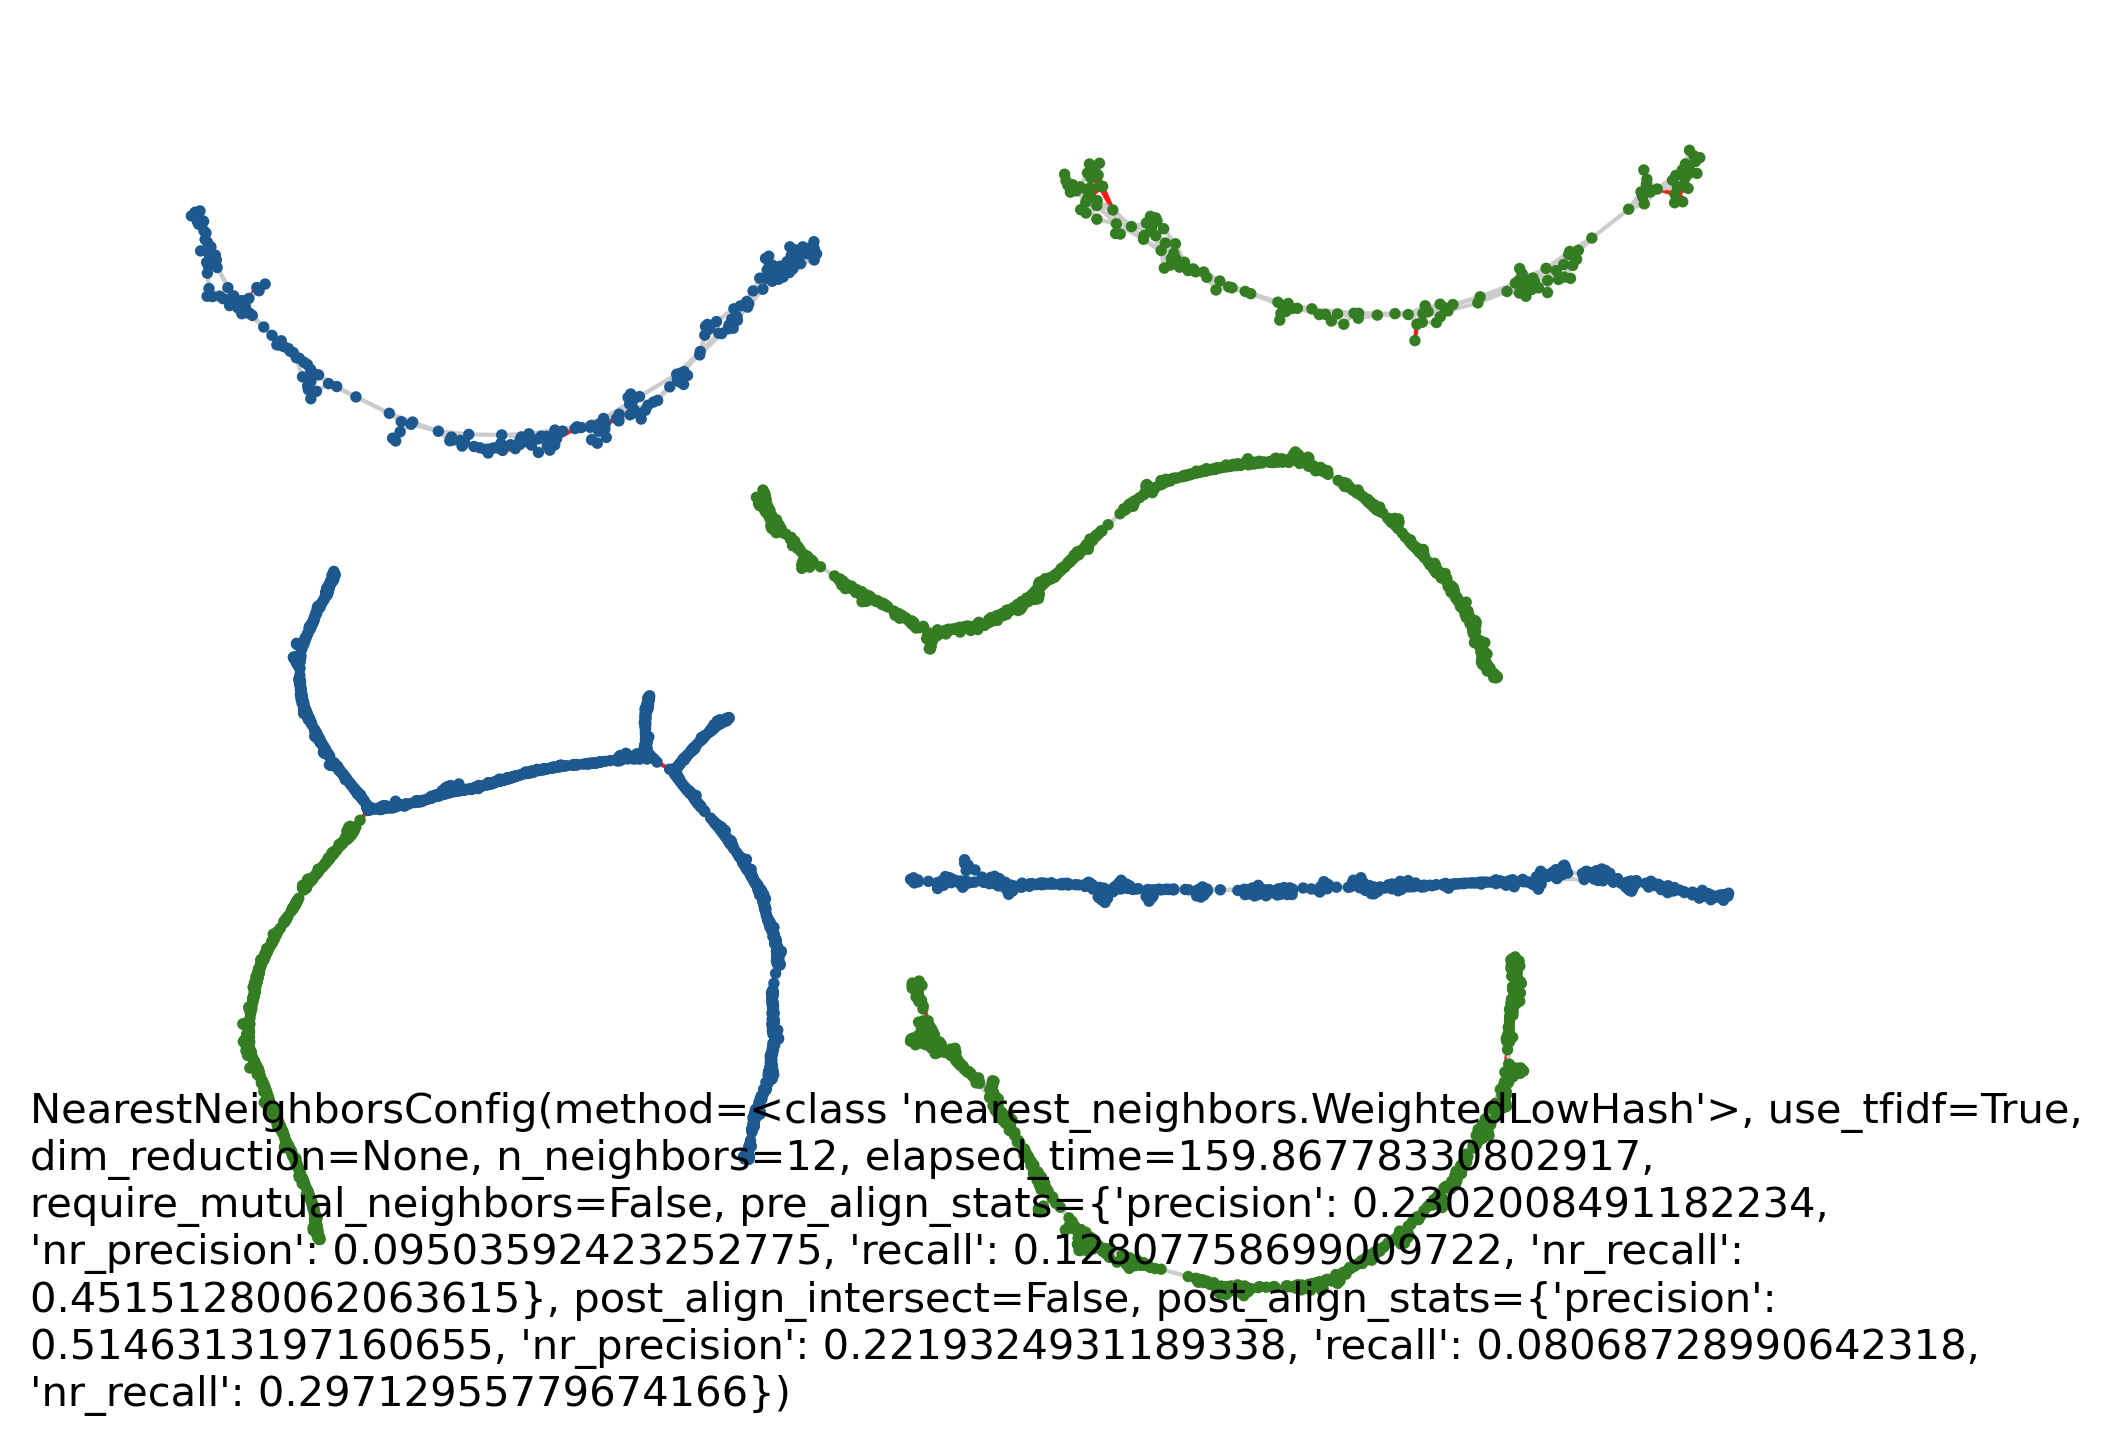

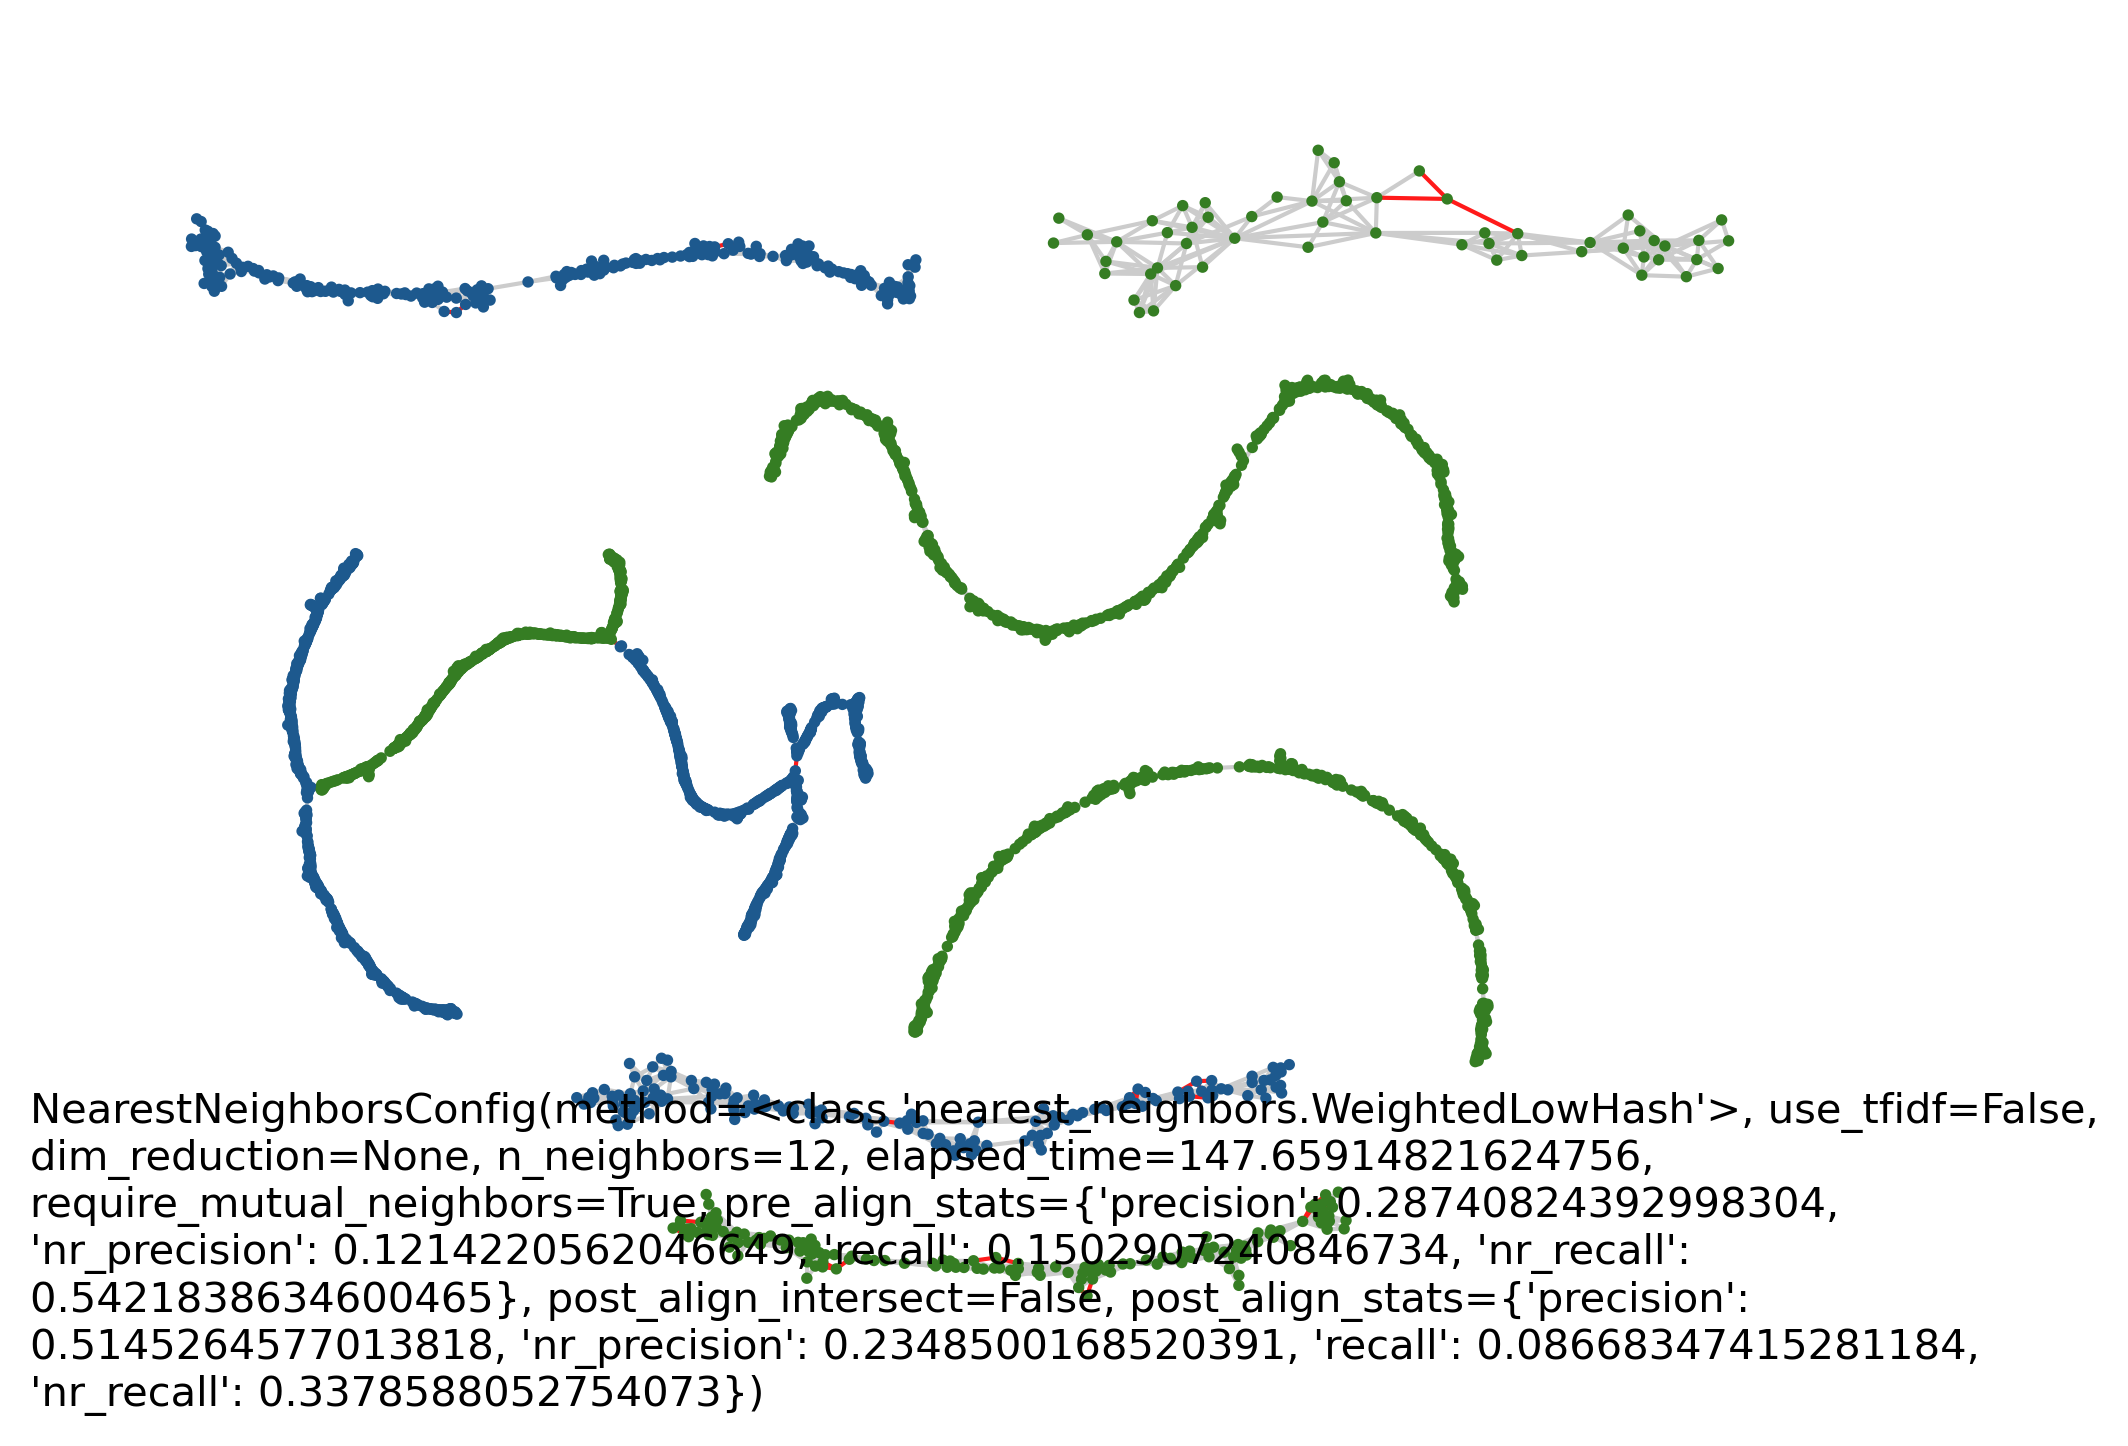

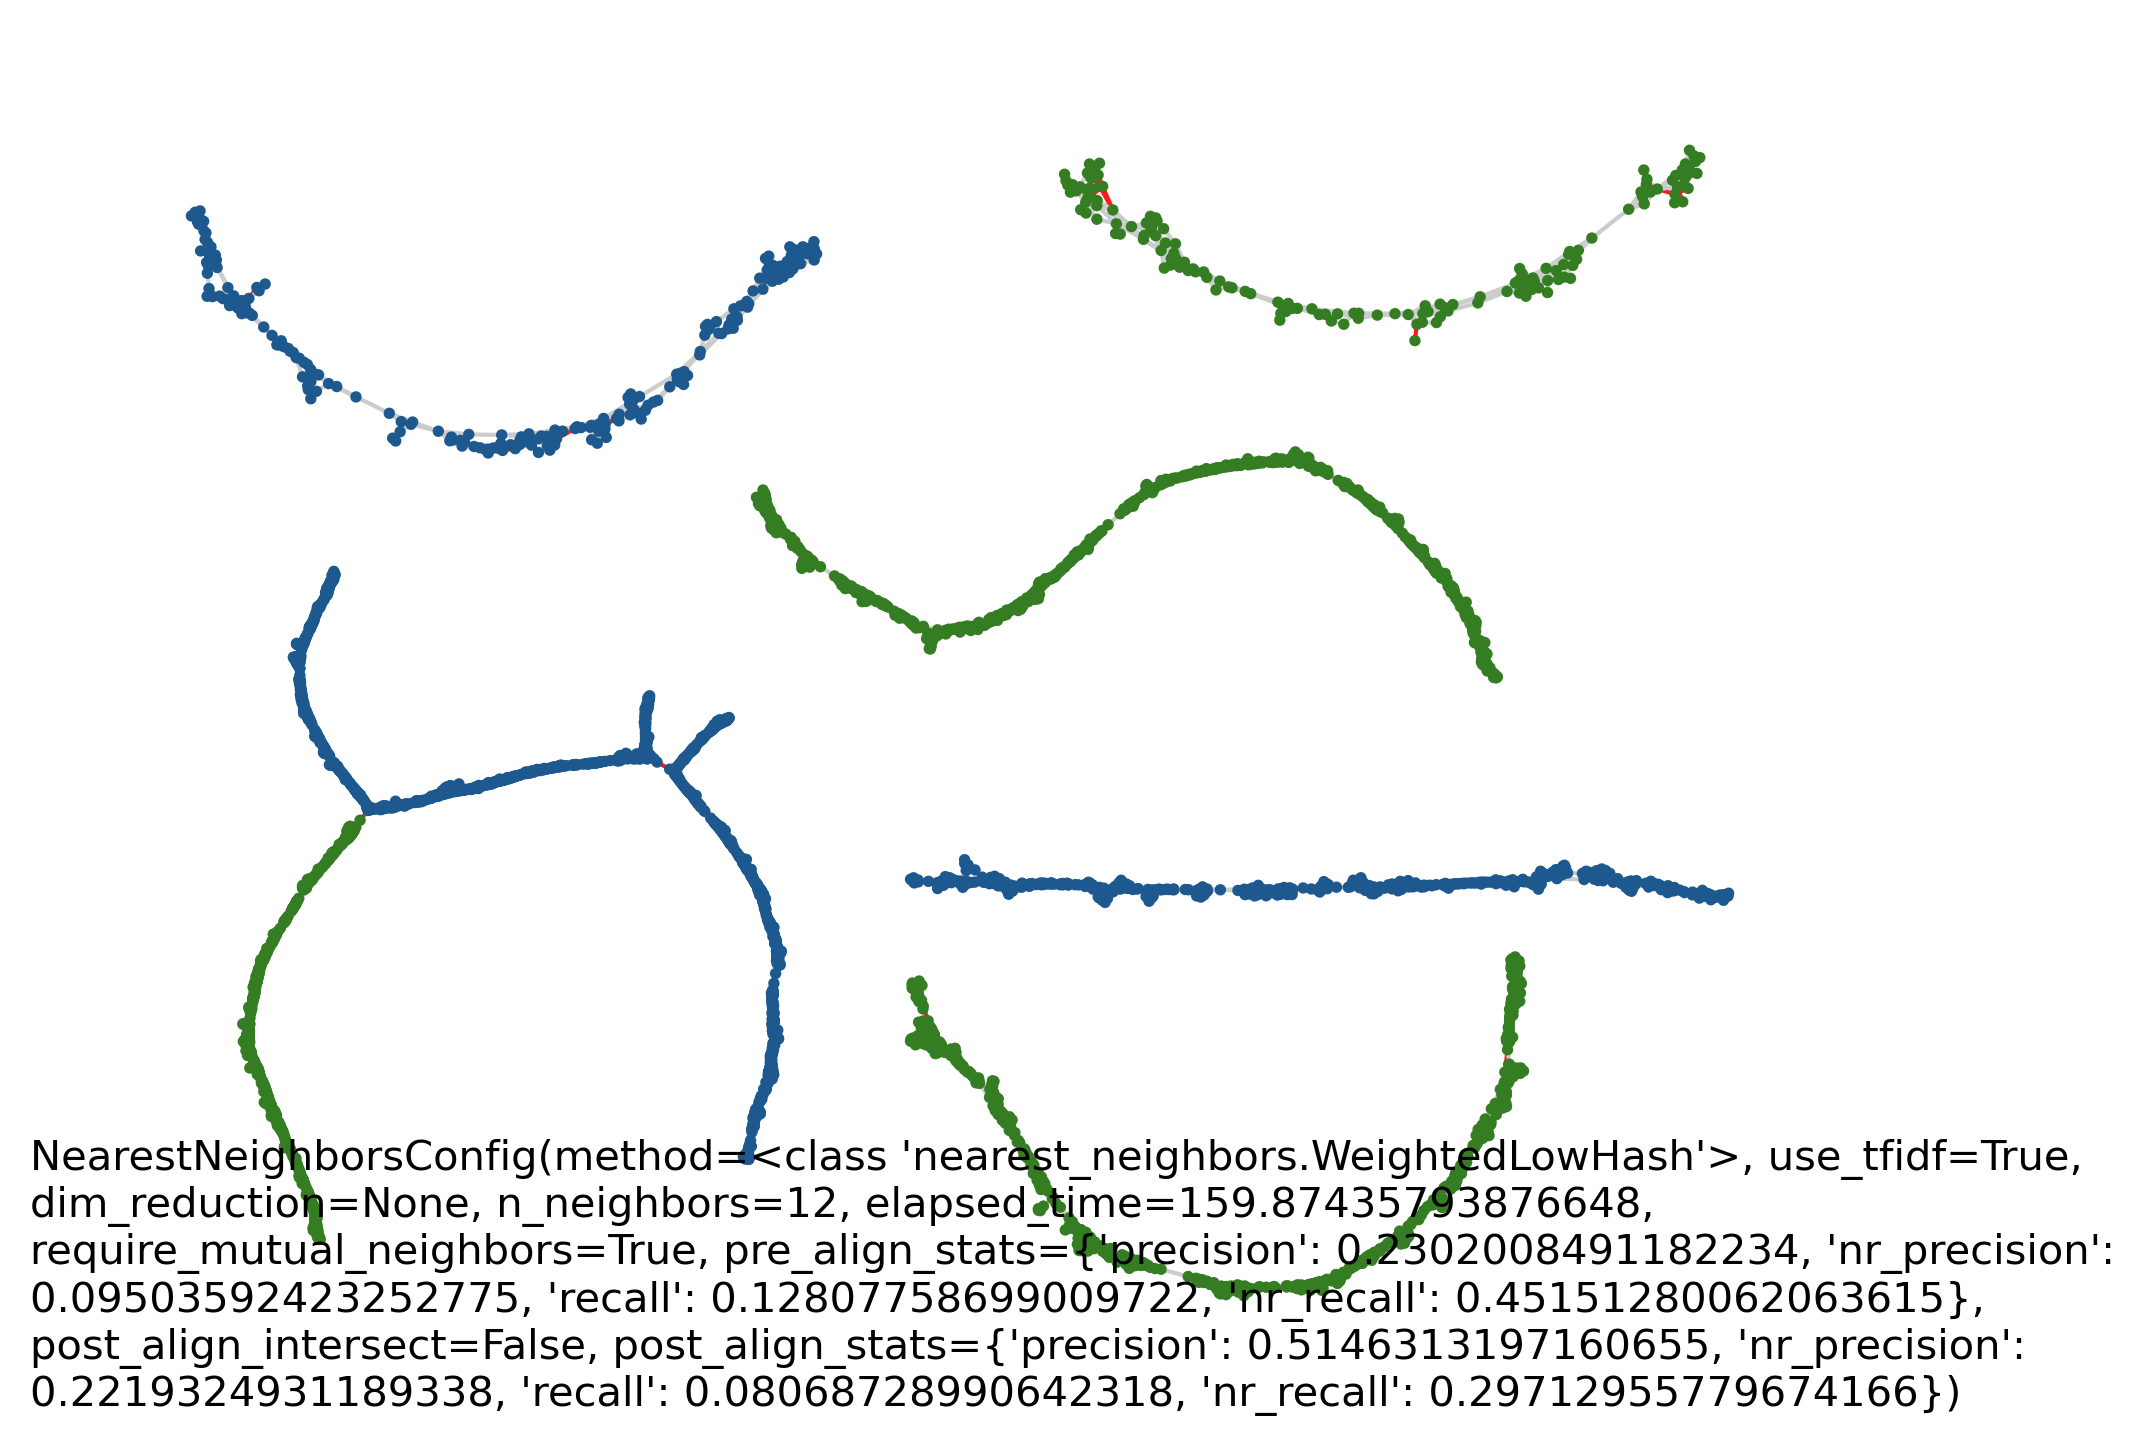

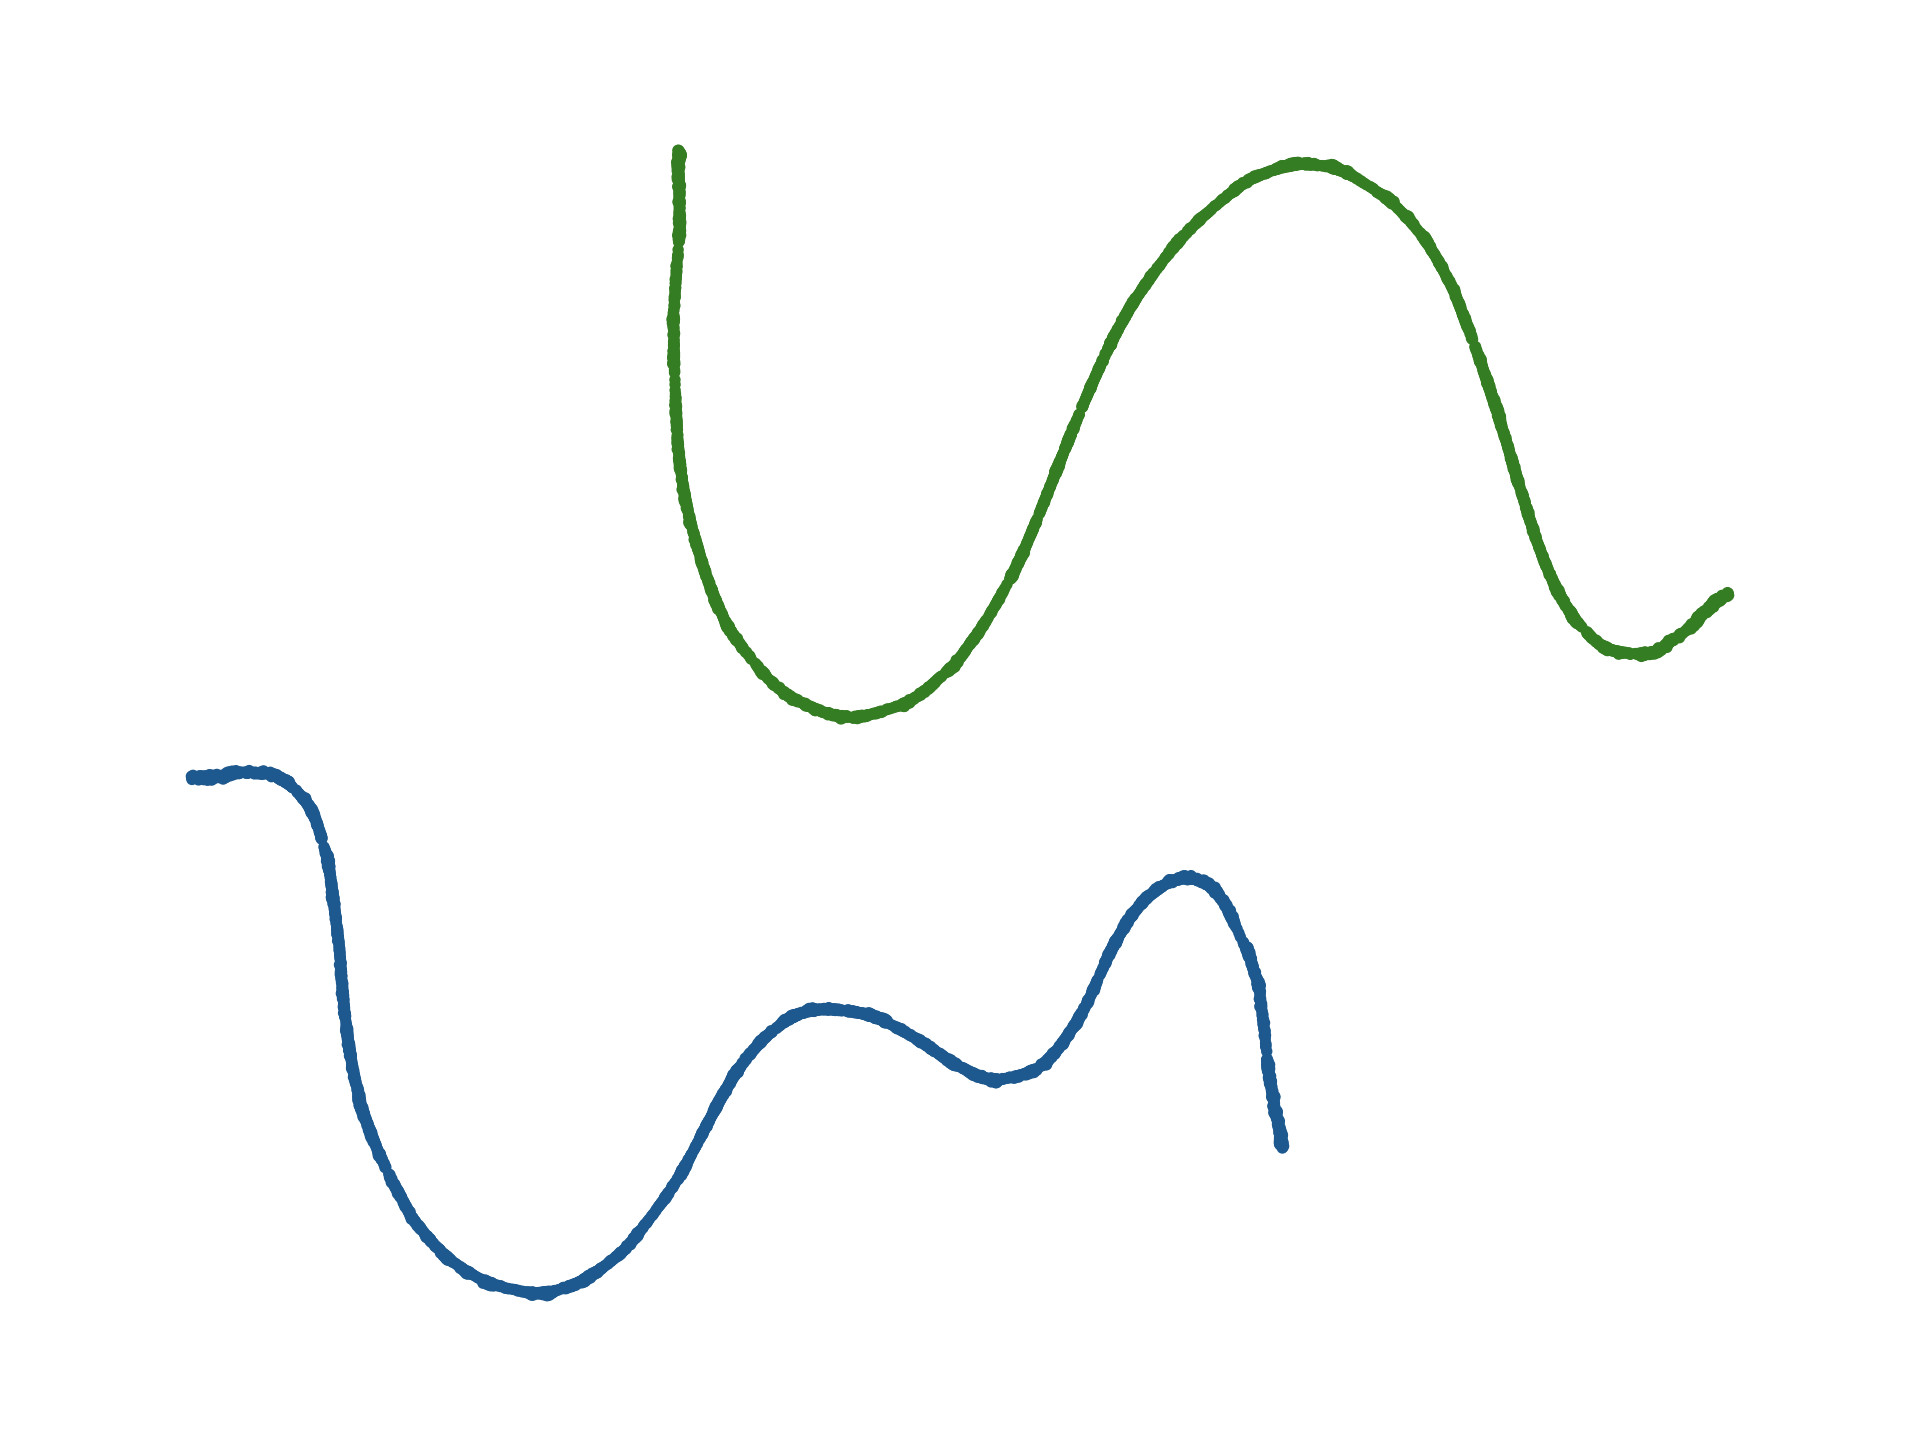

In [66]:
%%time
figures, axes = plot_configs(
    config_list, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=16
)